In [20]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib


opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [49]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)


print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
model = Net().to(device)
model.load_state_dict(torch.load("lenet_mnist_model.pth", map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [51]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [52]:
def test(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    adv_labels = []
    adv_pred = []

    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
          adv_labels.append(label.item())
          adv_pred.append(perturbed_pred.item())
          adv_examples.append(perturbed_image.squeeze().detach().cpu().numpy())
        #elif len(adv_examples) < num_display:
        #    adv_examples.append(
        #        (
        #            label.item(), 
        #            perturbed_pred.item(), 
        #            perturbed_image.squeeze().detach().cpu().numpy()
        #        )
        #    )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples, adv_labels, adv_pred

In [53]:
def test_real(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append(
                (
                    label.item(), 
                    perturbed_pred.item(), 
                    perturbed_image.squeeze().detach().cpu().numpy()
                )
            )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples

In [118]:
num_display = 5
accuracies_real = []
all_adv_examples_real = []
epsilons_real = [.05, .1, .15, .2, .25, .3, .4, .5]

for epsilon in epsilons_real:
    accuracy, adv_examples = test_real(model, test_loader, epsilon, device, num_display)
    accuracies_real.append(accuracy)
    all_adv_examples_real.append(adv_examples)

Epsilon: 0.05, Accuracy: 0.943
Epsilon: 0.1, Accuracy: 0.851
Epsilon: 0.15, Accuracy: 0.683
Epsilon: 0.2, Accuracy: 0.430
Epsilon: 0.25, Accuracy: 0.208
Epsilon: 0.3, Accuracy: 0.087
Epsilon: 0.4, Accuracy: 0.017
Epsilon: 0.5, Accuracy: 0.006


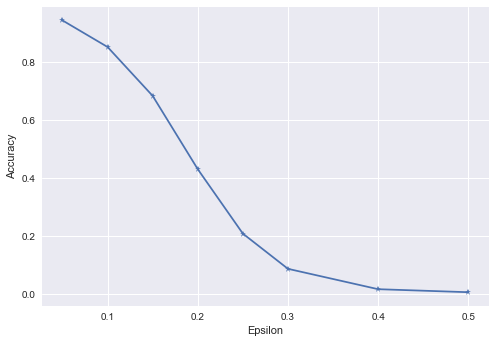

In [119]:
plt.style.use("seaborn")
plt.plot(epsilons_real, accuracies_real, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

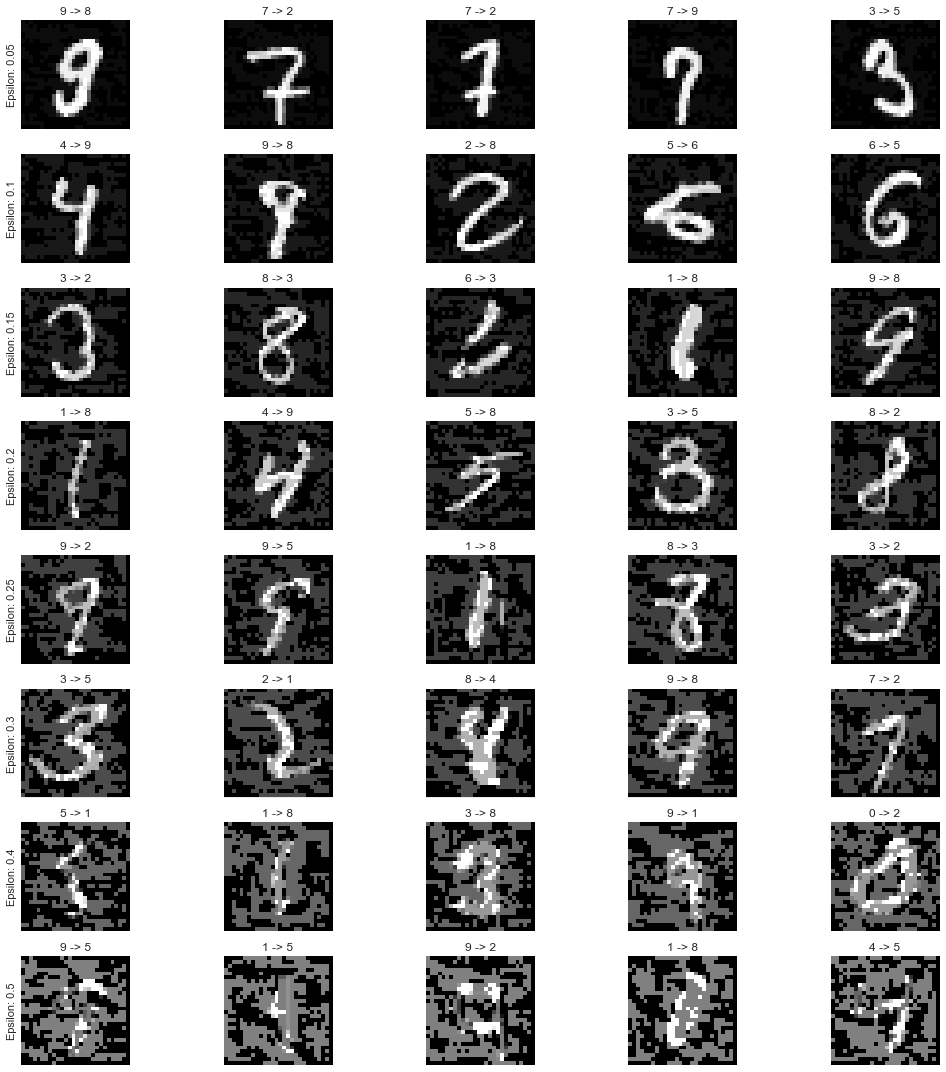

In [140]:
def clean_axis(axis):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    
nrows = len(epsilons_real)
ncols = 5

fig, ax = plt.subplots(8, 5, figsize=(15, 15))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples_real[row][col]
        axis = ax[row, col]
        axis.imshow(perturbed_image, cmap="gray")
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons_real[row]}")
plt.tight_layout()
plt.savefig('epsilontoimage.png')
plt.show()

In [54]:
num_display = 50000
accuracies_05 = []
all_adv_labels_3 = []
all_adv_preds_3 = []
all_adv_examples_3 = []
#epsilons = [.05, .1, .15, .2, .25, .3, .4, .5]
epsilons = [.3]

for epsilon in epsilons:
    accuracy, adv_examples, adv_labels, adv_pred = test(model, test_loader, epsilon, device, num_display)
    #accuracies.append(accuracy)
    all_adv_labels_3.append(adv_labels)
    all_adv_preds_3.append(adv_pred)
    all_adv_examples_3.append(adv_examples)

Epsilon: 0.3, Accuracy: 0.087


In [150]:
num_display = 50000
accuracies_05 = []
all_adv_labels_5 = []
all_adv_preds_5 = []
all_adv_examples_5 = []
#epsilons = [.05, .1, .15, .2, .25, .3, .4, .5]
epsilons = [.5]

for epsilon in epsilons:
    accuracy, adv_examples, adv_labels, adv_pred = test(model, test_loader, epsilon, device, num_display)
    #accuracies.append(accuracy)
    all_adv_labels_5.append(adv_labels)
    all_adv_preds_5.append(adv_pred)
    all_adv_examples_5.append(adv_examples)

Epsilon: 0.5, Accuracy: 0.006


In [ ]:
num_display = 50000
accuracies_05 = []
all_adv_labels_05 = []
all_adv_preds_05 = []
all_adv_examples_05 = []
#epsilons = [.05, .1, .15, .2, .25, .3, .4, .5]
epsilons = [.05]

for epsilon in epsilons:
    accuracy, adv_examples, adv_labels, adv_pred = test(model, test_loader, epsilon, device, num_display)
    #accuracies.append(accuracy)
    all_adv_labels_05.append(adv_labels)
    all_adv_preds_05.append(adv_pred)
    all_adv_examples_05.append(adv_examples)

In [58]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomTextDataset(Dataset):
    def __init__(self, text, labels, transforms):
        self.labels = labels
        self.text = text
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        text = self.text[idx]
        text = torch.tensor(text)
        if self.transforms:
            text = self.transforms(text)
        #sample = {"Text": text, "Class": label}
        sample = [text, label]
        return text, label
    
    
def make_dataloader(data, labels):
    customDataset = CustomTextDataset(data,labels,None)
    dataLoader = DataLoader(customDataset, batch_size=25)
    
    return dataLoader

In [236]:
DL_DS_05 = make_dataloader(all_adv_examples_05[0], all_adv_labels_05[0])
DL_DS_1 = make_dataloader(all_adv_examples_1[0], all_adv_labels_1[0])
DL_DS_15 = make_dataloader(all_adv_examples_15[0], all_adv_labels_15[0])
DL_DS_2 = make_dataloader(all_adv_examples_2[0], all_adv_labels_2[0])
DL_DS_25 = make_dataloader(all_adv_examples_25[0], all_adv_labels_25[0])
DL_DS_3 = make_dataloader(all_adv_examples_3[0], all_adv_labels_3[0])
DL_DS_4 = make_dataloader(all_adv_examples_4[0], all_adv_labels_4[0])
DL_DS_5 = make_dataloader(all_adv_examples_5[0], all_adv_labels_5[0])

In [37]:
# define data and class labels
import pandas as pd
from torchvision import transforms

train_data = adv_examples[0:800]
train_labels = adv_labels[0:800]

val_data = adv_examples[800:1000]
val_labels = adv_labels[800:1000]

test_data = adv_examples[1000:1300]
test_labels = adv_labels[1000:1300]

TD_train = CustomTextDataset(train_data,train_labels,None)
TD_val = CustomTextDataset(val_data,val_labels,None)
TD_test = CustomTextDataset(test_data,test_labels,None)

In [98]:
# define data and class labels
import pandas as pd
from torchvision import transforms

TD_all = CustomTextDataset(adv_examples,adv_labels,None)
DL_DS_all = DataLoader(TD_all, batch_size=25)

In [27]:
DL_DS_train = DataLoader(TD_train, batch_size=25)
DL_DS_val = DataLoader(TD_train, batch_size=25)
DL_DS_test = DataLoader(TD_test, batch_size=25)

In [201]:
test_data = adv_examples[1000:1300]
test_labels = adv_labels[1000:1300]
TD_test = CustomTextDataset(test_data,test_labels,None)
DL_DS_test = DataLoader(TD_test, batch_size=25)

## Variational Autoencoder with Gaussian Mixture 

In [27]:
# clone the github repository to access source code
#!git clone https://github.com/jariasf/GMVAE.git

# set the correct directory
%cd GMVAE/pytorch

[Errno 2] No such file or directory: 'GMVAE/pytorch'
/Users/emrey/588/GMVAE


In [28]:
import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=20,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

In [4]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

In [5]:
print("Loading mnist dataset...")

# load mnist data
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

# print dataset shape
print('Train size: ', len(train_dataset), ' Test size: ', len(test_dataset))

Loading mnist dataset...
Train size:  60000  Test size:  10000


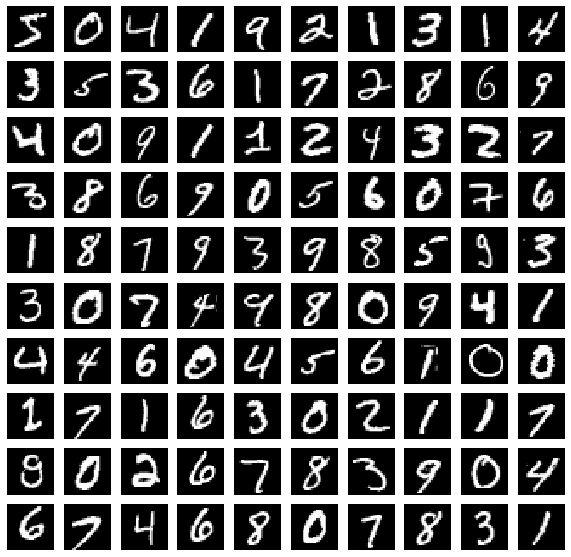

In [267]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_dataset[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [30]:
# For MNIST

def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0: 
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)


In [7]:
# Model Initialization
args.epochs = 1
gmvae2 = GMVAE(args)

history_loss2 = gmvae2.train(train_loader, val_loader)

(Epoch 1 / 1) Train_Loss: 176.639; Val_Loss: 149.191   Train_ACC: 33.273; Val_ACC: 49.040   Train_NMI: 23.501; Val_NMI: 44.321


In [16]:
gmvae2.network

GMVAENet(
  (inference): InferenceNet(
    (inference_qyx): ModuleList(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): GumbelSoftmax(
        (logits): Linear(in_features=512, out_features=10, bias=True)
      )
    )
    (inference_qzyx): ModuleList(
      (0): Linear(in_features=794, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Gaussian(
        (mu): Linear(in_features=512, out_features=64, bias=True)
        (var): Linear(in_features=512, out_features=64, bias=True)
      )
    )
  )
  (generative): GenerativeNet(
    (y_mu): Linear(in_features=10, out_features=64, bias=True)
    (y_var): Linear(in_features=10, out_features=64, bias=True)
    (generative_pxz): ModuleList(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU()
      (2): 

In [31]:
# Model Initialization
args.epochs = 100
gmvae = GMVAE(args)

In [33]:
# Training Phase
history_loss = gmvae.train(train_loader, val_loader)

(Epoch 1 / 100) Train_Loss: 175.786; Val_Loss: 147.579   Train_ACC: 38.767; Val_ACC: 56.900   Train_NMI: 26.426; Val_NMI: 49.594
(Epoch 2 / 100) Train_Loss: 139.810; Val_Loss: 134.037   Train_ACC: 57.787; Val_ACC: 58.970   Train_NMI: 49.239; Val_NMI: 52.939
(Epoch 3 / 100) Train_Loss: 131.280; Val_Loss: 128.877   Train_ACC: 59.770; Val_ACC: 60.270   Train_NMI: 51.750; Val_NMI: 53.675
(Epoch 4 / 100) Train_Loss: 127.204; Val_Loss: 125.002   Train_ACC: 60.627; Val_ACC: 61.890   Train_NMI: 52.963; Val_NMI: 56.185
(Epoch 5 / 100) Train_Loss: 124.364; Val_Loss: 122.846   Train_ACC: 62.503; Val_ACC: 61.790   Train_NMI: 54.655; Val_NMI: 55.820
(Epoch 6 / 100) Train_Loss: 122.591; Val_Loss: 121.238   Train_ACC: 64.200; Val_ACC: 64.260   Train_NMI: 56.324; Val_NMI: 57.727
(Epoch 7 / 100) Train_Loss: 121.242; Val_Loss: 120.640   Train_ACC: 65.652; Val_ACC: 66.220   Train_NMI: 57.353; Val_NMI: 58.591
(Epoch 8 / 100) Train_Loss: 120.286; Val_Loss: 119.721   Train_ACC: 67.412; Val_ACC: 67.720   Tra

(Epoch 65 / 100) Train_Loss: 112.431; Val_Loss: 115.033   Train_ACC: 83.438; Val_ACC: 83.600   Train_NMI: 76.372; Val_NMI: 76.649
(Epoch 66 / 100) Train_Loss: 112.421; Val_Loss: 115.030   Train_ACC: 83.927; Val_ACC: 83.780   Train_NMI: 76.814; Val_NMI: 76.660
(Epoch 67 / 100) Train_Loss: 112.373; Val_Loss: 114.529   Train_ACC: 83.898; Val_ACC: 83.620   Train_NMI: 77.186; Val_NMI: 77.173
(Epoch 68 / 100) Train_Loss: 112.309; Val_Loss: 114.674   Train_ACC: 84.065; Val_ACC: 84.030   Train_NMI: 76.861; Val_NMI: 76.706
(Epoch 69 / 100) Train_Loss: 112.315; Val_Loss: 114.669   Train_ACC: 83.895; Val_ACC: 83.820   Train_NMI: 76.712; Val_NMI: 77.528
(Epoch 70 / 100) Train_Loss: 112.282; Val_Loss: 114.859   Train_ACC: 84.143; Val_ACC: 84.160   Train_NMI: 77.128; Val_NMI: 77.467
(Epoch 71 / 100) Train_Loss: 112.202; Val_Loss: 114.709   Train_ACC: 84.165; Val_ACC: 84.810   Train_NMI: 77.080; Val_NMI: 77.609
(Epoch 72 / 100) Train_Loss: 112.165; Val_Loss: 114.526   Train_ACC: 84.448; Val_ACC: 84.3

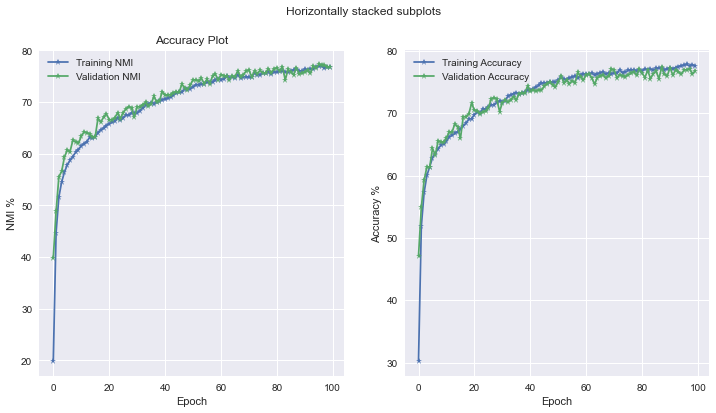

In [364]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Horizontally stacked subplots')
ax1.plot([i for i in range(len(history_loss['train_history_nmi']))], history_loss['train_history_nmi'], "*-", label = 'Training NMI')
ax1.plot([i for i in range(len(history_loss['val_history_nmi']))], history_loss['val_history_nmi'], "*-", label = 'Validation NMI')
ax1.set(xlabel='Epoch', ylabel='NMI %')
ax1.title.set_text('NMI Plot')
ax1.legend()

ax2.plot([i for i in range(len(history_loss['train_history_acc']))], history_loss['train_history_acc'], "*-", label = 'Training Accuracy')
ax2.plot([i for i in range(len(history_loss['val_history_acc']))], history_loss['val_history_acc'], "*-", label = 'Validation Accuracy')
ax2.set(xlabel='Epoch', ylabel='Accuracy %')
ax1.title.set_text('Accuracy Plot')
ax2.legend()
plt.show() 

In [272]:
def print_results(model, epoch, test_loader, DL_DS_all):
    print('Epoch {}'.format(epoch))
    print('--------')

    accuracy, nmi = model.test(test_loader)
    print("Testing phase...")
    print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi))

    print('--------')

    accuracy_dl, nmi_dl = model.test(DL_DS_all)

    print("Testing phase...")
    print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy_dl, nmi_dl))
    
    return accuracy_dl, nmi_dl

In [273]:
accuracy, nmi = gmvae.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi))

Testing phase...
Accuracy: 76.81000,  NMI: 76.74332


In [47]:
accuracy, nmi = gmvae.test(DL_DS_all)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 32.46154,  NMI: 21.97166


In [76]:
print_results(gmvae, 20, test_loader, DL_DS_all)

Epoch 20
--------
Testing phase...
Accuracy: 74.97000,  NMI: 69.24176
--------
Testing phase...
Accuracy: 35.69231,  NMI: 25.83437


In [110]:
print_results(gmvae, 100, test_loader, DL_DS_all)

Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 25.50466,  NMI: 16.50731


In [274]:
accuracy, nmi = gmvae.test(DL_DS_all)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 20.47101,  NMI: 11.28683


In [275]:
dataloaders = [DL_DS_05, DL_DS_1, DL_DS_15,DL_DS_2,DL_DS_25,DL_DS_3,DL_DS_4,DL_DS_5]
accuracy_score = []
nmi_score = []
for dl in dataloaders:
    accuracy_dl, nmi_dl = print_results(gmvae, 100, test_loader, dl)
    
    accuracy_score.append(accuracy_dl)
    nmi_score.append(nmi_dl)

Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 38.02083,  NMI: 29.75376
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 31.92308,  NMI: 21.33271
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 29.08847,  NMI: 16.20358
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 24.48720,  NMI: 13.64047
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 20.47101,  NMI: 11.28683
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 19.04709,  NMI: 9.12554
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
--------
Testing phase...
Accuracy: 16.00124,  NMI: 4.74249
Epoch 100
--------
Testing phase...
Accuracy: 76.81000,  NMI: 76.74332
-------

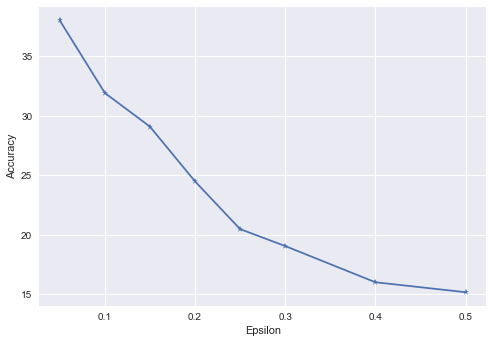

In [276]:
plt.style.use("seaborn")
plt.plot(epsilons_real, accuracy_score, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

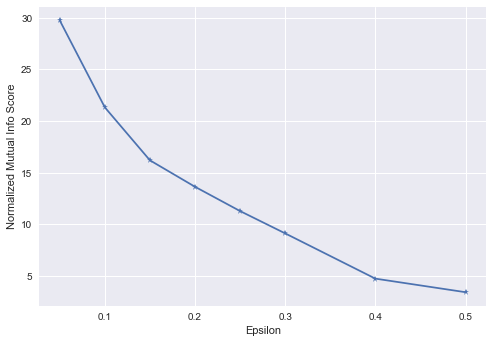

In [277]:
plt.style.use("seaborn")
plt.plot(epsilons_real, nmi_score, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Normalized Mutual Info Score")
plt.show()

In [291]:
[x * 0.01 for x in accuracy_score]

[0.3802083333333333,
 0.3192307692307692,
 0.29088471849865954,
 0.24487202759121438,
 0.20471014492753623,
 0.1904708645565373,
 0.16001244426008504,
 0.15163640094388017]

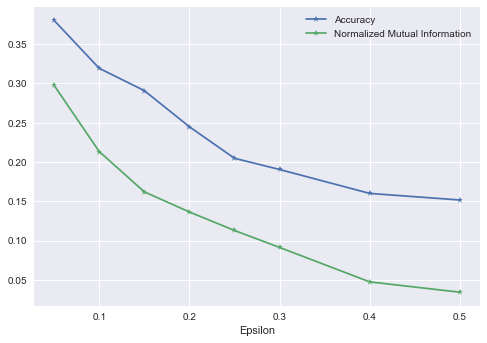

In [302]:
plt.style.use("seaborn")
plt.plot(epsilons_real, [x * 0.01 for x in accuracy_score], "*-", label='Accuracy')
plt.plot(epsilons_real, [x * 0.01 for x in nmi_score], "*-", label='Normalized Mutual Information')
plt.xlabel("Epsilon")
plt.legend()
plt.show()

In [237]:
print_results(gmvae, 100, test_loader, DL_DS_05)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_1)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_15)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_2)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_25)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_3)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_4)
print('*****')
print_results(gmvae, 100, test_loader, DL_DS_5)

Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 39.84375,  NMI: 32.18728
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 33.30769,  NMI: 25.65022
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 29.25603,  NMI: 21.04756
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 27.59121,  NMI: 18.04445
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 25.50466,  NMI: 16.50731
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 23.00638,  NMI: 14.96924
*****
Epoch 100
--------
Testing phase...
Accuracy: 69.23000,  NMI: 71.55943
--------
Testing phase...
Accuracy: 20.07674,  NMI: 11.60660
*****
Epoch 100
--------
Testing phase..

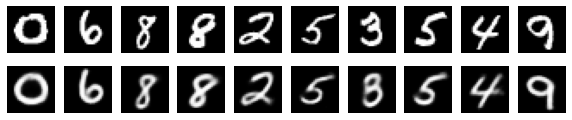

In [318]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[n,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = gmvae.reconstruct_data(test_loader, 10)  
display_reconstructed(original, reconstructed, 10)

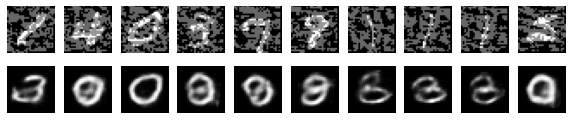

In [325]:
# Epoch 20
original, reconstructed = gmvae.reconstruct_data(DL_DS_4, 10)  
display_reconstructed(original, reconstructed, 10)

In [222]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_loader, True)

In [112]:
# get feature representations
adv_test_features, adv_test_labels = gmvae.latent_features(DL_DS_all, True)

In [225]:
#result_dict = dict(keys=[0,1,2,3,4,5,6,7,8,9], values=[])
keyList = [0,1,2,3,4,5,6,7,8,9]
# Using Dictionary comprehension
result_dict = {key: [] for key in keyList}
for data, label in zip(test_features, test_labels):
    result_dict[label].append(data)

# Using Dictionary comprehension
mean_list = {key: [] for key in keyList}
for k in range(10):
    mean_list[k] = np.average(np.array(result_dict[k]), axis=0)

In [ ]:
def print_results(model, test_loader, DL_DS_all):
    print('Epoch 20')
    print('--------')

    accuracy, nmi = model.test(test_loader)
    print("Testing phase...")
    print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi))

    print('--------')

    accuracy, nmi = model.test(DL_DS_all)

    print("Testing phase...")
    print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi))

In [95]:
from scipy.spatial.distance import mahalanobis
import numpy as np
import pandas as pd
import math

def calculate_mahalanobis(list1, list2):
# define the two points
    p1 = np.array(list1)
    p2 = np.array(list2)

    V = np.cov(np.array([p1, p2]).T)
    IV = np.linalg.inv(V)
    print(np.det(IV))

    return mahalanobis(p1, p2, IV)

def calculate_euclidean(list1, list2):
    p1 = np.array(list1)
    p2 = np.array(list2)
    
    return np.sum(np.square(p1 - p2))

def is_rejected(distance, mean_vector):
    three_sigma = (mean_vector.std()) * 3
    if distance > three_sigma:
        #print('1: {} - {}'.format(distance, three_sigma))
        return 1
    elif math.isnan(distance):
        return 1
    else:
        #print('0: {} - {}'.format(distance, three_sigma))
        return 0
    
def calculate_rejection(dataloader, epsilon):
    
    adv_data, adv_labels = gmvae.latent_features(dataloader, True)
    
    mahalaresults = []
    rejected_binary = []
    counter = 0
    for data, label in zip(adv_data, adv_labels):
        try:
            distance_value = calculate_mahalanobis(data, mean_list[label])
            #distance_value = calculate_euclidean(data, mean_list[label])
            rejected_value = is_rejected(distance_value, mean_list[label])

            mahalaresults.append(distance_value)
            rejected_binary.append(rejected_value)
        except:
            counter = counter + 1
    print('Epsion: {}'.format(epsilon))
    print(pd.Series(rejected_binary).value_counts())
    print('Rejected Rate: {}'.format(sum(rejected_binary) / len(rejected_binary)))
    print('Singular Matrix {}'.format(counter))
    
    return rejected_binary, mahalaresults

In [233]:
for k in range(10):
    print('{} and mean: {}'.format(k,mean_list[k].mean()))

0 and mean: 0.10358454104615013
1 and mean: 0.012508651081842917
2 and mean: 0.06129883416142645
3 and mean: 0.022410209265531257
4 and mean: 0.12780690415537346
5 and mean: -0.01620992867895009
6 and mean: 0.13887842475664036
7 and mean: 0.07395075359379737
8 and mean: 0.06671239222880243
9 and mean: 0.1257490624248465


In [249]:
calculate_rejection(DL_DS_05, 0.5)
calculate_rejection(DL_DS_1, 1)
calculate_rejection(DL_DS_15, 1.5)
calculate_rejection(DL_DS_2, 2)
calculate_rejection(DL_DS_25, 2.5)
calculate_rejection(DL_DS_3, 3)
calculate_rejection(DL_DS_4, 4)
calculate_rejection(DL_DS_5, 5)

Epsion: 0.5
1    370
0     14
dtype: int64
Rejected Rate: 0.9635416666666666
Epsion: 1
1    1278
0      22
dtype: int64
Rejected Rate: 0.9830769230769231
Epsion: 1.5
1    2905
0      79
dtype: int64
Rejected Rate: 0.9735254691689008
Epsion: 2
1    5384
0     125
dtype: int64
Rejected Rate: 0.9773098565982937
Epsion: 2.5
1    7561
0     167
dtype: int64
Rejected Rate: 0.9783902691511387
Epsion: 3
1    8767
0     174
dtype: int64
Rejected Rate: 0.9805390895872945
Epsion: 4
1    9419
0     224
dtype: int64
Rejected Rate: 0.9767707145079332
Epsion: 5
1    9530
0     217
dtype: int64
Rejected Rate: 0.9777367395095927


([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [374]:
calculate_rejection(train_loader, 0.5)

Epsion: 0.5
1    58677
0     1323
dtype: int64
Rejected Rate: 0.97795


([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


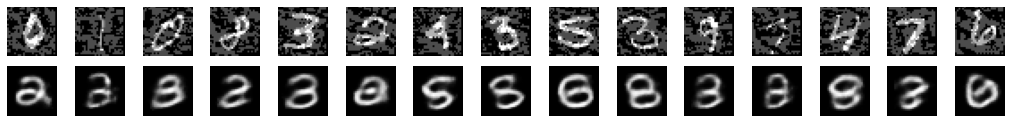

In [255]:
original, reconstructed = gmvae.reconstruct_data(DL_DS_3, 15)  
display_reconstructed(original, reconstructed, 15)

In [59]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

def visualize_tsne(features, labels):
  tsne_features = TSNE(n_components=2).fit_transform(features[:1000,])
  fig = plt.figure(figsize=(10, 6))

  plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels[:tsne_features.shape[0]], marker='o',
              edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
  plt.grid(False)
  plt.axis('off')
  plt.colorbar()

/Users/emrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/emrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


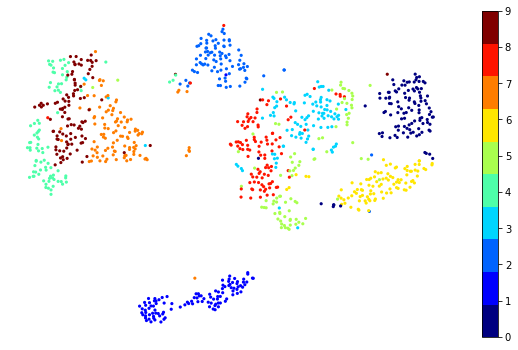

In [60]:
visualize_tsne(test_features, test_labels)

/Users/emrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/emrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


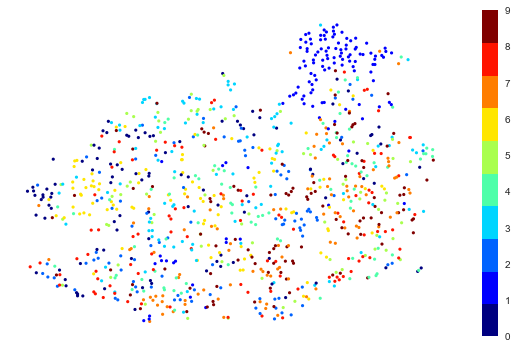

In [330]:
adv_test_features_05, adv_test_labels_05 = gmvae.latent_features(DL_DS_4, True)
visualize_tsne(adv_test_features_05, adv_test_labels_05)